In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv('../data/cleaned.csv')
df.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104


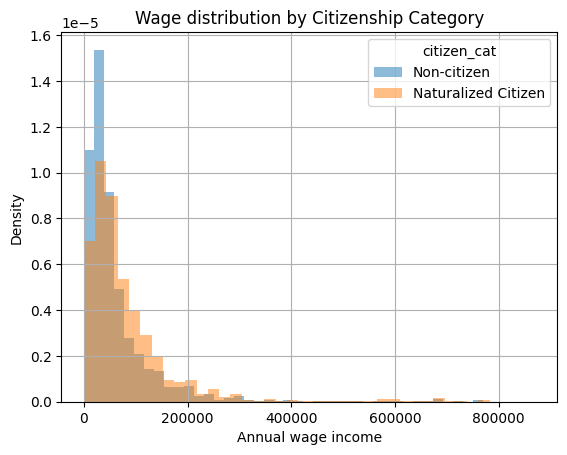

In [ ]:
d = {1: "Naturalized Citizen", 0: "Non-citizen"}

for cat, group in df.groupby("CITIZEN"):
    group["INCWAGE"].hist(
        bins=40, 
        alpha=0.5,
        density = True,
        label=d[cat]
    )

plt.xlabel("Annual wage income")
plt.ylabel("Density")
plt.title("Wage distribution by Citizenship Category")
plt.legend(title="Citizenship Status")
plt.show()

## Propensity Score Visualizations

### Logistic Reg

In [5]:
df_lr = df.copy()
prop_formula = "CITIZEN ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND)"

prop_model = smf.logit(prop_formula, data=df_lr).fit(disp=False)
df_lr["e_hat"] = prop_model.predict(df)
df_lr["e_hat"] = df_lr["e_hat"].clip(0.01, 0.99)
df_lr.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.913634
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.913634
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.913634
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.592551
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104,0.143931


### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

df_rf = df.copy()
cat_vars = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]
X = pd.get_dummies(df_rf[["AGE", "YEARS_IN_US"] + cat_vars], drop_first=True)
T = df_rf["CITIZEN"].values
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=20,
    random_state=0,
    n_jobs=-1
)
rf.fit(X, T)
df_rf["e_hat"] = rf.predict_proba(X)[:, 1]
df_rf["e_hat"] = df_rf["e_hat"].clip(0.01, 0.99)